In [ ]:
'''
    测试一个文件夹下所有模型在test集上的结果，并画出ROC曲线
'''

In [1]:
import argparse
import os
import torch
import torch.nn as nn
from conf import global_settings as settings
import torch.optim as optim

import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import time
from datetime import datetime

#画ROC曲线
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

#导入模型
from models.resnet import resnet18
from utils import get_training_dataloader, get_test_dataloader, WarmUpLR, \
    most_recent_folder, most_recent_weights, last_epoch, best_acc_weights, get_network

Attention(
  (pre_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (stage1): Sequential(
    (0): PreActResidualUnit(
      (residual_function): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): ReLU(inplace=True)
        (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
    )
    (1): Att

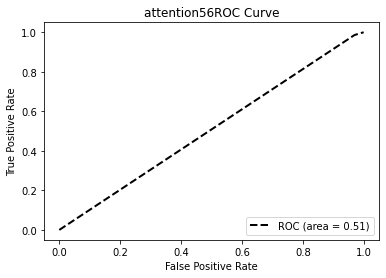

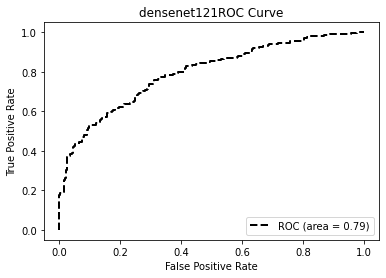

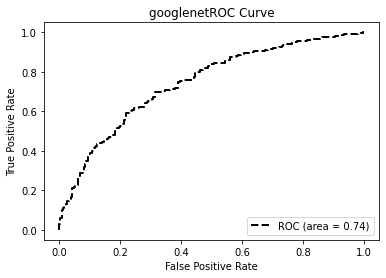

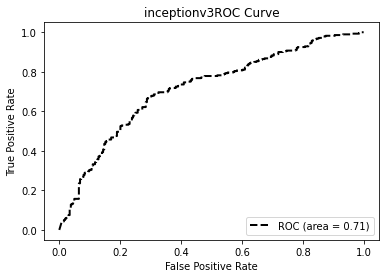

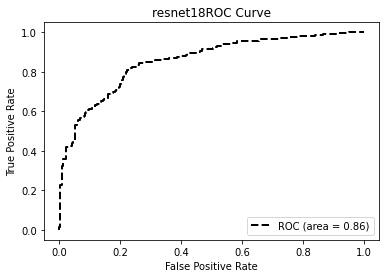

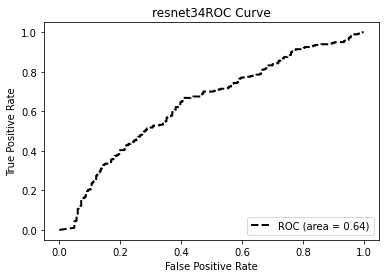

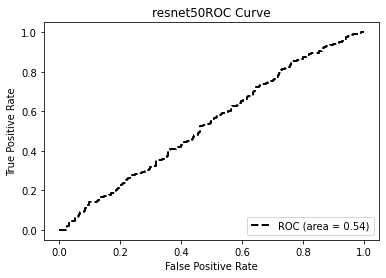

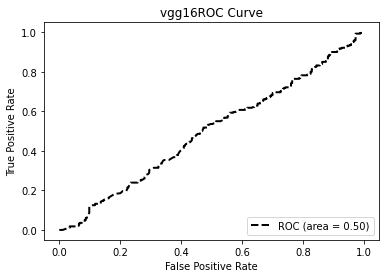

In [9]:
pthfile=r'checkpoint\2'
roc_curve_file=os.path.join(pthfile,'ROC_curve')
if not os.path.exists(roc_curve_file):
    os.makedirs(roc_curve_file)
details_list=[]
for file in os.listdir(pthfile):
    if not file[-4:]=='.pth':
        continue
    net_name=file.split('-')[0]
    net=get_network(net_name)
    if settings.GPU:
        net=net.cuda()
    cifar100_test_loader = get_test_dataloader(
        settings.CIFAR100_TRAIN_MEAN,
        settings.CIFAR100_TRAIN_STD,
        #settings.CIFAR100_PATH,
        num_workers=0,
        batch_size=settings.BATCH_SIZE,
    )

    net.load_state_dict(torch.load(os.path.join(pthfile,file)))
    print(net)
    net.eval()

    correct_1 = 0.0
    # correct_5 = 0.0
    total = 0
    y_true=[]
    y_score=[]

    with torch.no_grad():
        for n_iter, (image, label) in enumerate(cifar100_test_loader):
            print("iteration: {}\ttotal {} iterations".format(n_iter + 1, len(cifar100_test_loader)))

            if settings.GPU:
                image = image.cuda()
                label = label.cuda()
                print('GPU INFO.....')
                print(torch.cuda.memory_summary(), end='')

            output = net(image)
            #获取最大可能的切片
            # softmax=nn.LogSoftmax(dim=1)
            # output=softmax(output)

            '''
                第一个是多分类使用
                第二个是二分类使用
            '''
            # pro, pred = output.topk(1, 1, largest=True, sorted=True)
            # label = label.view(label.size(0), -1).expand_as(pred)
            output=output.view(-1)
            print(output)
            print(label)
            pred = (output > 0.5).to(torch.int)

            correct = pred.eq(label).float()

            # 记录label和概率用于画ROC曲线
            y_true.extend(label.cpu().numpy().reshape(-1).tolist())
            y_score.extend(output.cpu().numpy().reshape(-1).tolist())
            #compute top 5
            #correct_5 += correct[:, :5].sum()

            #compute top1
            #correct_1 += correct[:, :1].sum()
            correct_1 += correct.sum()

    if settings.GPU:
        print('GPU INFO.....')
        print(torch.cuda.memory_summary(), end='')
    details=''
    details+=net_name+' details:\n'
    details+=f'total:{len(cifar100_test_loader.dataset)},correct:{correct_1},'
    details+=f'acc:{correct_1 / len(cifar100_test_loader.dataset)}'
    par_num=sum(p.numel() for p in net.parameters())
    details+=f'\nParameter numbers:{par_num}'
    print(f'total:{len(cifar100_test_loader.dataset)},correct:{correct_1}')
    print("Top 1 err: ", 1 - correct_1 / len(cifar100_test_loader.dataset))
    # print("Top 5 err: ", 1 - correct_5 / len(cifar100_test_loader.dataset))
    print("Parameter numbers: {}".format(par_num))

    #画ROC曲线
    # print(y_true)
    # print(y_score)
    fpr, tpr, thersholds = roc_curve(y_true, y_score)
    auc_value=auc(fpr,tpr)
    # 逆序输出标签，概率
    # for i, value in enumerate(thersholds):
    #     print("%f %f %f" % (fpr[i], tpr[i], value))

    roc_auc = auc(fpr, tpr)
    details+=f'\nauc:{roc_auc}'
    print(f'auc={auc_value}')
    fig=plt.figure()
    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)

    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
    plt.title(net_name+'ROC Curve')
    plt.legend(loc="lower right")
    #plt.show()
    img_name=file[:-9]+'_roc.png'
    fig.savefig(os.path.join(roc_curve_file,img_name))
    details_list.append(details)

In [10]:
for details in details_list:
    print(details)
    print('\n\n')

attention56 details:
total:544,correct:284.0,acc:0.5220588445663452
Parameter numbers:55499777
auc:0.508008658008658



densenet121 details:
total:544,correct:391.0,acc:0.71875
Parameter numbers:6945921
auc:0.7939935064935065



googlenet details:
total:544,correct:376.0,acc:0.6911764740943909
Parameter numbers:6299937
auc:0.7420860389610388



inceptionv3 details:
total:544,correct:362.0,acc:0.6654411554336548
Parameter numbers:22114721
auc:0.7120806277056277



resnet18 details:
total:544,correct:431.0,acc:0.7922794222831726
Parameter numbers:11168193
auc:0.8564529220779221



resnet34 details:
total:544,correct:337.0,acc:0.6194853186607361
Parameter numbers:21276353
auc:0.6392248376623378



resnet50 details:
total:544,correct:301.0,acc:0.5533088445663452
Parameter numbers:23501249
auc:0.5367153679653679



vgg16 details:
total:544,correct:285.0,acc:0.5238970518112183
Parameter numbers:33608641
auc:0.4957656926406926



